In [2]:
!pip install numpy<2 pandas torch scikit-learn matplotlib IPython

The system cannot find the file specified.


In [7]:
!pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [6]:
!pip install numpy==1.26.4

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   --- ------------------------------------ 1.3/15.5 MB 7.4 MB/s eta 0:00:02
   -------- ------------------------------- 3.1/15.5 MB 7.7 MB/s eta 0:00:02
   ------------ --------------------------- 4.7/15.5 MB 7.9 MB/s eta 0:00:02
   ----------------- ---------------------- 6.8/15.5 MB 8.2 MB/s eta 0:00:02
   --------------------- ------------------ 8.4/15.5 MB 8.3 MB/s eta 0:00:01
   -------------------------- ------------- 10.2/15.5 MB 8.2 MB/s eta 0:00:01
   ------------------------------ --------- 11.8/15.5 MB 8.1 MB/s eta 0:00:01
   ----------------------------------- ---- 13.6/15.5 MB 8.1 MB/s eta 0:00:01
   ------------------------------------- -- 14.7/15.5 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uni

In [8]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
display.set_matplotlib_formats("svg")

iris = pd.read_csv("https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv")
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [9]:
# Convert both x features and y target variables to PyTorch
X = torch.tensor(iris.drop("variety", axis=1).values, dtype=torch.float)
y = torch.tensor(
    [0 if vty == "Setosa" else 1 if vty == "Versicolor" else 2 for vty in iris["variety"]], 
    dtype=torch.long
)

print(X.shape, y.shape)

torch.Size([150, 4]) torch.Size([150])


In [10]:
# Train/test split on 80%. 12 batches with 10 samples as 120 120 in the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

print("Training data batches:")
for X, y in train_loader:
    print(X.shape, y.shape)
    
print("\nTest data batches:")
for X, y in test_loader:
    print(X.shape, y.shape)

Training data batches:
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])

Test data batches:
torch.Size([30, 4]) torch.Size([30])


In [11]:
# First model to build with 1 hidden layer and 16 nodes
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(in_features=4, out_features=16)
        self.hidden_1 = nn.Linear(in_features=16, out_features=16)
        self.output = nn.Linear(in_features=16, out_features=3)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        return self.output(x)
    
    
model = Net()
print(model)

Net(
  (input): Linear(in_features=4, out_features=16, bias=True)
  (hidden_1): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)


In [12]:
# This is the training section
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    # Train set
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )
    
    # Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

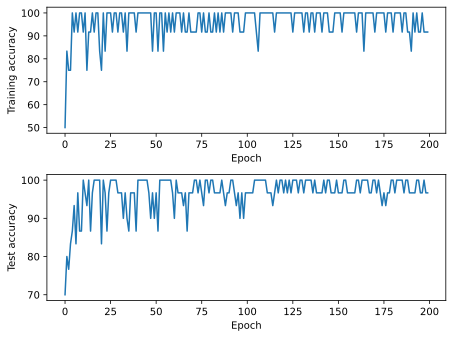

In [13]:
# Plot the accuracy of training and test
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

In [16]:
# Optimization and will also obtain training and testing accuracy
def train_model(train_loader, test_loader, model, lr=0.01, num_epochs=200):
    train_accuracies, test_accuracies = [], []
    losses = []
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        for X, y in train_loader:
            preds = model(X)
            pred_labels = torch.argmax(preds, axis=1)
            loss = loss_function(preds, y)
            losses.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_accuracies.append(
            100 * torch.mean((pred_labels == y).float()).item()
        )
        
        X, y = next(iter(test_loader))
        pred_labels = torch.argmax(model(X), axis=1)
        test_accuracies.append(
            100 * torch.mean((pred_labels == y).float()).item()
        )
 
    return train_accuracies[-1], test_accuracies[-1]


train_model(train_loader, test_loader, Net())

(91.66666865348816, 100.0)

In [17]:
## Different model building class
class Net2(nn.Module):
    def __init__(self, n_units, n_layers):
        super().__init__()
        self.n_layers = n_layers
        
        self.layers = nn.ModuleDict()
        self.layers["input"] = nn.Linear(in_features=4, out_features=n_units)
        
        for i in range(self.n_layers):
            self.layers[f"hidden_{i}"] = nn.Linear(in_features=n_units, out_features=n_units)
            
        self.layers["output"] = nn.Linear(in_features=n_units, out_features=3)
        
    def forward(self, x):
        x = self.layers["input"](x)
        
        for i in range(self.n_layers):
            x = F.relu(self.layers[f"hidden_{i}"](x))
            
        return self.layers["output"](x)

In [18]:
# Optimization here. 1 -> 4 layers.
# Each layer having either 8, 16, 24, 32, 40, 48, 56 or 56 nodes
n_layers = np.arange(1, 5)
n_units = np.arange(8, 65, 8)
train_accuracies, test_accuracies = [], []

for i in range(len(n_units)):
    for j in range(len(n_layers)):
        model = Net2(n_units=n_units[i], n_layers=n_layers[j])
        train_acc, test_acc = train_model(train_loader, test_loader, model)
        train_accuracies.append({
            "n_layers": n_layers[j],
            "n_units": n_units[i],
            "accuracy": train_acc
        })
        test_accuracies.append({
            "n_layers": n_layers[j],
            "n_units": n_units[i],
            "accuracy": test_acc
        })
        
        
train_accuracies = pd.DataFrame(train_accuracies).sort_values(by=["n_layers", "n_units"]).reset_index(drop=True)
test_accuracies = pd.DataFrame(test_accuracies).sort_values(by=["n_layers", "n_units"]).reset_index(drop=True)
test_accuracies.head()

,n_layers,n_units,accuracy
0,1,8,100.000000
1,1,16,100.000000
2,1,24,100.000000
3,1,32,96.666664
4,1,40,100.000000


In [19]:
# What is the best model architecture? Highest accuracy on the test set layers?
test_accuracies[test_accuracies["accuracy"] == test_accuracies["accuracy"].max()]

,n_layers,n_units,accuracy
0,1,8,100.0
1,1,16,100.0
2,1,24,100.0
4,1,40,100.0
5,1,48,100.0
6,1,56,100.0
8,2,8,100.0
12,2,40,100.0
16,3,8,100.0
17,3,16,100.0


In [20]:
# Torchviz - Visualize PyTorch Neural Networks with a Single Function Call
# Need to install graphviz
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4137 sha256=b6d6401b55931b14ebac73fd9ce89969bce74c2b0f0a10267f32365c3ad4395f
  Stored in directory: C:\Users\b-m-s\AppData\Local\Temp\pip-ephem-wheel-cache-d724ybpu\wheels\98\f2\3d\290537e0ff7f67aaa647847a10fb5ee5eca305b3c41a774523
Successfully built torchviz


In [25]:
from torchviz import make_dot

model = Net()
y = model(X)

In [26]:
make_dot(y.mean(), params=dict(model.named_parameters()))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [28]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/14.4 MB ? eta -:--:--
    --------------------------------------- 0.3/14.4 MB ? eta -:--:--
    --------------------------------------- 0.3/14.4 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.4 MB 728.2 kB/s eta 0:00:20
   -- ------------------------------------- 0.8/14.4 MB 907.1 kB/s eta 0:00:16
   -- ------------------------------------- 1.0/14.4 MB 1.0 MB/s eta 0:00:14
   --- ------------------------------------ 1.3/14.4 MB 1.1 MB/s eta 0:00:12
   ---- ----------------------------------- 1.6/14.4 MB 1.2 MB/s eta 0:00:12
   ----- ---------------------------------- 1.8/14.4 MB 1.2 MB/s eta 0:00:11
   ----- ---------------------------------- 2.1/14.4 MB 1.2 MB/s eta 0:00:11
   ------ --------------------------------- 2.4/14.4 MB 1.2 MB/s eta 0:00:10
   ------- -------------------------------- 2.6/14.4 MB 1.2 MB/s eta 0:00:10
   ------- ---------

In [29]:
# For use with Netron - Export to onnx to the visulise
input_names = ["Iris"]
output_names = ["Iris Species Prediction"]

torch.onnx.export(model, X, "model.onnx", input_names=input_names, output_names=output_names)

In [ ]:
# Could also the use TensorBoard